In [2]:
# Cell 1: Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from PIL import Image
import os

# Load the model
model = MobileNetV2(weights='imagenet')

In [3]:
# Cell 2: Image Loading and Preprocessing Function
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image for the model."""
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    
    # Convert to RGB if grayscale
    if len(img_array.shape) == 2:
        img_array = np.stack((img_array,) * 3, axis=-1)
    
    # Remove alpha channel if present
    if img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]
    
    return img_array

In [4]:
# Cell 3: PGD Attack Implementation
def pgd_attack(image, model, eps=0.1, alpha=0.01, max_iterations=10, targeted=False, target_class=None):
    """
    Perform a PGD attack on the image.
    
    Args:
        image: Input image (numpy array)
        model: TensorFlow model
        eps: Maximum perturbation size (L1 norm)
        alpha: Step size for each iteration
        max_iterations: Number of iterations for the attack
        targeted: Whether to perform a targeted attack
        target_class: Target class index for targeted attack
    
    Returns:
        Adversarial image
    """
    # Preprocess the image for the model
    img_preprocessed = preprocess_input(image[np.newaxis, ...].astype(np.float32))
    
    # Get the original prediction
    original_pred = model.predict(img_preprocessed)
    original_class_idx = np.argmax(original_pred[0])
    
    # Create a copy of the original image to modify
    adversarial_image = tf.identity(img_preprocessed)
    
    # Define loss function based on attack type
    if targeted:
        # For targeted attack, we want to maximize the probability of the target class
        def loss_func(label, prediction):
            return -tf.keras.losses.categorical_crossentropy(label, prediction)
    else:
        # For untargeted attack, we want to minimize the probability of the original class
        def loss_func(label, prediction):
            return tf.keras.losses.categorical_crossentropy(label, prediction)
    
    # Create one-hot encoded label
    label = np.zeros((1, 1000))  # ImageNet has 1000 classes
    if targeted:
        label[0, target_class] = 1
    else:
        label[0, original_class_idx] = 1
    
    # Perform PGD attack
    for i in range(int(max_iterations)):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            prediction = model(adversarial_image)
            loss = loss_func(label, prediction)
        
        # Compute gradients
        gradients = tape.gradient(loss, adversarial_image)
        
        # Calculate the L1 norm of the gradient
        gradients_norm = tf.norm(gradients, ord=1)
        # Avoid division by zero
        normalized_gradients = gradients / (gradients_norm + 1e-8)
        
        if targeted:
            # Targeted attack: move in the opposite direction of the gradient
            adversarial_image = adversarial_image - alpha * normalized_gradients
        else:
            # Untargeted attack: move in the same direction of the gradient
            adversarial_image = adversarial_image + alpha * normalized_gradients
        
        # Now we measure the new perturbation
        perturbation = adversarial_image - img_preprocessed
        
        # Project (clip) the perturbation back into the L1-ball of radius eps
        current_norm = tf.norm(perturbation, ord=1)
        if current_norm > eps:
            # Scale down
            perturbation = perturbation * (eps / current_norm)
        
        # Reconstruct the adversarial image from the clipped perturbation
        adversarial_image = img_preprocessed + perturbation
        
        # Finally, clip pixel values to [0,1] so they remain valid
        adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)
    
    # Convert back to numpy array
    adversarial_image = adversarial_image.numpy()[0]
    
    # Denormalize for visualization
    adversarial_image = adversarial_image * 255.0
    adversarial_image = np.clip(adversarial_image, 0, 255).astype(np.uint8)
    
    return adversarial_image

In [5]:
# Cell 3: PGD Attack Implementation
def pgd_attack(image, model, eps=0.1, alpha=0.01, max_iterations=10, targeted=False, target_class=None):
    """
    Perform a PGD attack on the image.
    
    Args:
        image: Input image (numpy array)
        model: TensorFlow model
        eps: Maximum perturbation size (L1 norm)
        alpha: Step size for each iteration
        max_iterations: Number of iterations for the attack
        targeted: Whether to perform a targeted attack
        target_class: Target class index for targeted attack
    
    Returns:
        Adversarial image
    """
    # Preprocess the image for the model
    img_preprocessed = preprocess_input(image[np.newaxis, ...].astype(np.float32))
    
    # Get the original prediction
    original_pred = model.predict(img_preprocessed)
    original_class_idx = np.argmax(original_pred[0])
    
    # Create a copy of the original image to modify
    adversarial_image = tf.identity(img_preprocessed)
    
    # Define loss function based on attack type
    if targeted:
        # For targeted attack, we want to maximize the probability of the target class
        def loss_func(label, prediction):
            return -tf.keras.losses.categorical_crossentropy(label, prediction)
    else:
        # For untargeted attack, we want to minimize the probability of the original class
        def loss_func(label, prediction):
            return tf.keras.losses.categorical_crossentropy(label, prediction)
    
    # Create one-hot encoded label
    label = np.zeros((1, 1000))  # ImageNet has 1000 classes
    if targeted:
        label[0, target_class] = 1
    else:
        label[0, original_class_idx] = 1
    
    # Perform PGD attack
    for i in range(int(max_iterations)):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            prediction = model(adversarial_image)
            loss = loss_func(label, prediction)
        
        # Compute gradients
        gradients = tape.gradient(loss, adversarial_image)
        
        # Calculate the L1 norm of the gradient
        gradients_norm = tf.norm(gradients, ord=1)
        # Avoid division by zero
        normalized_gradients = gradients / (gradients_norm + 1e-8)
        
        if targeted:
            # Targeted attack: move in the opposite direction of the gradient
            adversarial_image = adversarial_image - alpha * normalized_gradients
        else:
            # Untargeted attack: move in the same direction of the gradient
            adversarial_image = adversarial_image + alpha * normalized_gradients
        
        # Now we measure the new perturbation
        perturbation = adversarial_image - img_preprocessed
        
        # Project (clip) the perturbation back into the L1-ball of radius eps
        current_norm = tf.norm(perturbation, ord=1)
        if current_norm > eps:
            # Scale down
            perturbation = perturbation * (eps / current_norm)
        
        # Reconstruct the adversarial image from the clipped perturbation
        adversarial_image = img_preprocessed + perturbation
        
        # Finally, clip pixel values to [0,1] so they remain valid
        adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)
    
    # Convert back to numpy array
    adversarial_image = adversarial_image.numpy()[0]
    
    # Denormalize for visualization
    adversarial_image = adversarial_image * 255.0
    adversarial_image = np.clip(adversarial_image, 0, 255).astype(np.uint8)
    
    return adversarial_image

In [6]:
# Cell 4: Visualization Function
def visualize_attack(original_image, adversarial_image, model, save_path=None):
    """Visualize the original and adversarial images with their classifications."""
    # Get predictions for original image
    original_preprocessed = preprocess_input(original_image[np.newaxis, ...].astype(np.float32))
    original_pred = model.predict(original_preprocessed)
    original_class = decode_predictions(original_pred, top=1)[0][0][1].replace('_', ' ').title()
    original_conf = float(original_pred.max()) * 100
    
    # Get predictions for adversarial image
    adversarial_preprocessed = preprocess_input(adversarial_image[np.newaxis, ...].astype(np.float32))
    adversarial_pred = model.predict(adversarial_preprocessed)
    adversarial_class = decode_predictions(adversarial_pred, top=1)[0][0][1].replace('_', ' ').title()
    adversarial_conf = float(adversarial_pred.max()) * 100
    
    # Calculate perturbation
    perturbation = adversarial_image.astype(np.float32) - original_image.astype(np.float32)
    # Normalize perturbation for visualization
    perturbation_vis = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original: {original_class}\nConfidence: {original_conf:.2f}%")
    plt.axis('off')
    
    # Plot adversarial image
    plt.subplot(1, 3, 2)
    plt.imshow(adversarial_image)
    plt.title(f"Adversarial: {adversarial_class}\nConfidence: {adversarial_conf:.2f}%")
    plt.axis('off')
    
    # Plot perturbation
    plt.subplot(1, 3, 3)
    plt.imshow(perturbation_vis)
    plt.title("Perturbation Visualization")
    plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    
    plt.show()
    
    return original_class, original_conf, adversarial_class, adversarial_conf

2025-04-07 20:34:05.691 python[15987:772204] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-07 20:34:06.611 python[15987:772204] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Visualization saved to pgd_attack_visualization.png


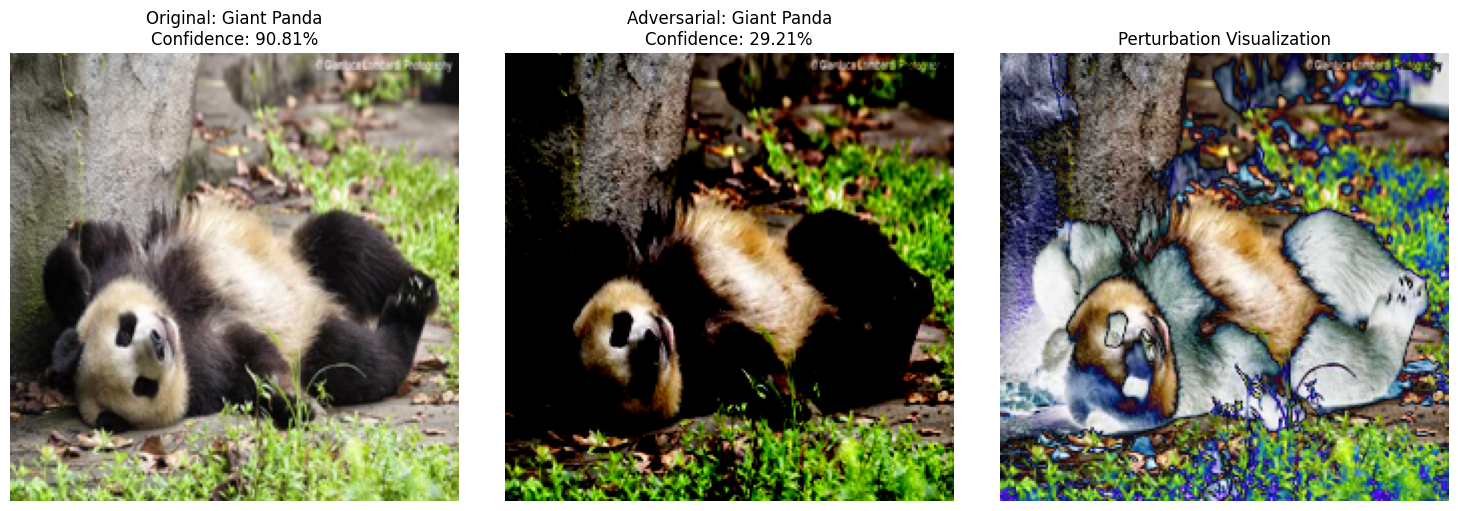

Original classification: Giant Panda (Confidence: 90.81%)
Adversarial classification: Giant Panda (Confidence: 29.21%)
Visualization saved to pgd_attack_visualization.png


In [8]:
# Cell 5: Example Usage
# Example usage

from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Hide the root window
Tk().withdraw()

# Open a file dialog to select an image file
image_path = askopenfilename(title="Select an image file", filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.tiff")])

# Load and preprocess the image
original_image = load_and_preprocess_image(image_path)

# Parameters for the attack
eps = 0.1  # Maximum perturbation size
alpha = 0.01  # Step size
max_iterations = 10  # Number of iterations

# Perform the attack
adversarial_image = pgd_attack(
    original_image, 
    model, 
    eps=eps, 
    alpha=alpha, 
    max_iterations=max_iterations,
    targeted=False
)

# Visualize the results
save_path = "pgd_attack_visualization.png"
original_class, original_conf, adversarial_class, adversarial_conf = visualize_attack(
    original_image, 
    adversarial_image, 
    model, 
    save_path=save_path
)

print(f"Original classification: {original_class} (Confidence: {original_conf:.2f}%)")
print(f"Adversarial classification: {adversarial_class} (Confidence: {adversarial_conf:.2f}%)")
print(f"Visualization saved to {save_path}")